### **Import Library:** 분석에 사용할 모듈 설치

In [16]:
# Ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# Data manipulation and visualization
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 20
pd.options.display.max_columns = 20
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn import preprocessing

# Modeling algorithms
# General
import statsmodels.api as sm
from scipy import stats

# Model selection
from sklearn.model_selection import train_test_split

# Evaluation metrics
from sklearn import metrics
# for classification
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.metrics import roc_curve, auc, precision_recall_curve

### **Data Loading:** 분석에 사용할 데이터 불러오기

In [13]:
df = pd.read_csv('./data/Titanic.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.00,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.00,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.00,0,0,111369,30.00,C148,C


|     **변수**     |                           **설명**                          |
|:------------:|:-------------------------------------------------------:|
| **PassengerId**  |                        승객 번호                        |
|   **Survived**   |                 생존여부(1:생존, 0:사망)                |
|    **Pclass**    |           승선권 클래스(1:1st, 2:2nd, 3:3rd)            |
|     **Name**     |                        승객 이름                        |
|     **Sex**      |                        승객 성별                        |
|     **Age**      |                        승객 나이                        |
|    **SibSp**     |                동반한 형제자매, 배우자 수               |
|    **Patch**     |                   동반한 부모, 자식 수                  |
|    **Ticket**    |                     티켓의 고유 넘버                    |
|     **Fare**     |                       티켓의 요금                       |
|    **Cabin**     |                        객실 번호                        |
|   **Embarked**   | 승선한 항구명(C:Cherbourg, Q:Queenstown, S:Southampton) |

### **Preprocessing:** 데이터 정리 및 패턴 추출하기

In [19]:
# 결측값 처리
def fillnull(df):
    # Age
    # 정규분포와 유사하여 평균으로 결측치 처리
    df_agem = df[df.Sex == 'male']
    df_agem = df_agem[['Age']].fillna(df_agem[['Age']].mean())

    df_agefm = df[df.Sex == 'female']
    df_agefm = df_agefm[['Age']].fillna(df_agefm[['Age']].mean())
    df[['Age']] = pd.concat([df_agem, df_agefm], axis=0).sort_index()

    # Embarked
    # 최빈값으로 결측값 제거
    df[['Embarked']] = df[['Embarked']].fillna(df['Embarked'].mode()[0], axis=0)

    # Cabin
    # 제일 앞글자만 남기고 기존값 대체, nan 값은 Temp로 대체
    df['Cabin'] = df['Cabin'].str.slice(0, 1)
    df['Cabin'] = df['Cabin'].fillna('Temp')

    return df

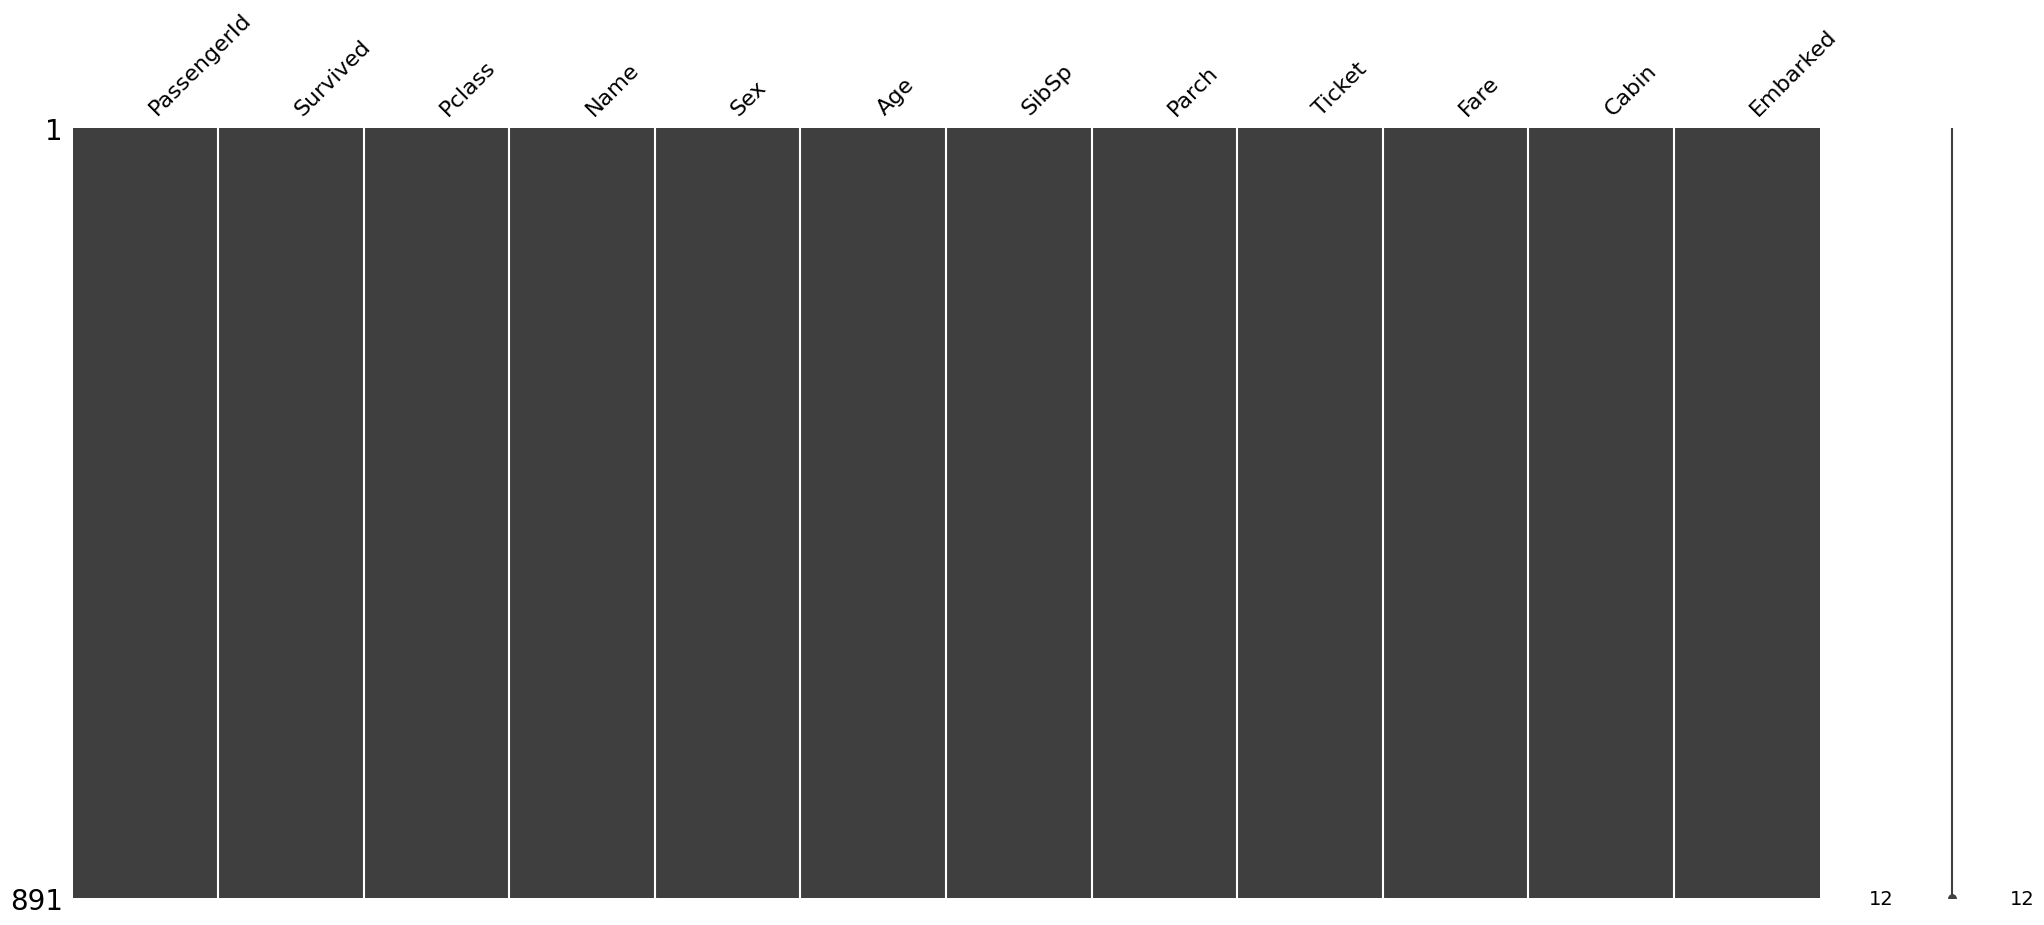

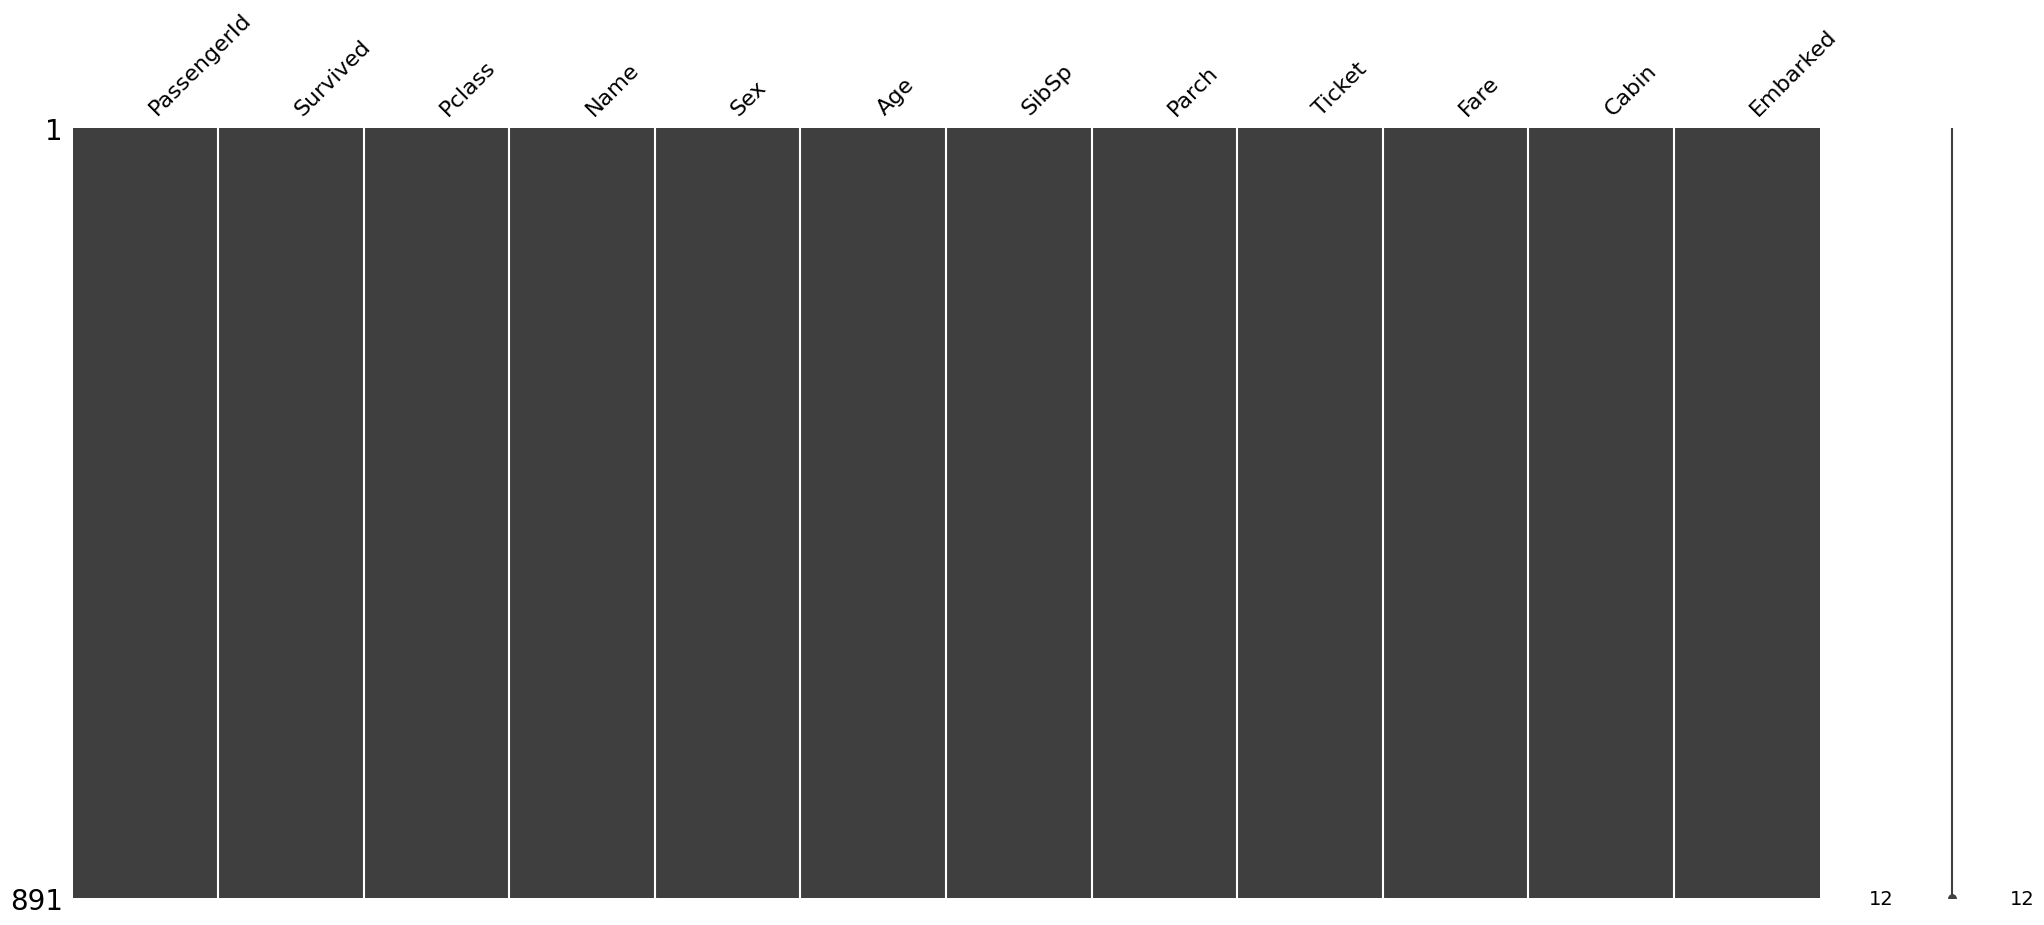

In [20]:
# 결측치 정보를 missingno 함수를 사용하여 확인하기
# 위 함수를 사용하여 결측치를 처리하기
# 결측치 처리 후 missingno 함수를 사용하여 변화 확인하기

# 결측치 처리 전
msno.matrix(df)
plt.show()

# 결측치 처리 후
df = fillnull(df)
msno.matrix(df)
plt.show()

In [22]:
# 데이터 정리
def prep(df):
    # Name
    # 각 호칭별로 새로운 직군으로 클러스터링
    name_sub = df['Name'].str.split(',', expand=True)[1]
    name_sub = name_sub.str.split('. ', expand=True)[0]
    name_sub.replace([' Mr'], 'Mr', inplace=True)
    name_sub.replace([' Mrs'], 'Mrs', inplace=True)
    name_sub.replace([' Ms', ' Miss'], 'Miss', inplace=True)
    name_sub.replace([' Don', ' Mme', ' Lady', 'Sir', 'Mlle', ' th', ' Jonkheer'], 'Noble', inplace=True)
    name_sub.replace([' Master', ' Major', ' Col', ' Capt', ' Sir', ' Mlle'], 'Officer', inplace=True)
    name_sub.replace([' Dr', ' Rev'], 'Priest', inplace=True)
    df['Name'] = name_sub.copy()

    # Ticket
    # 값들의 .제거 + /제거
    # 앞뒤공백제거 + 가운데공백으로 분리
    # 숫자값은 문자열 NUM으로 대체
    df['Ticket'] = df['Ticket'].str.replace('.', '').str.replace('/', '')
    df['Ticket'] = df['Ticket'].str.strip().str.split(' ').str[0]
    df.loc[df['Ticket'].str.isdigit(), 'Ticket'] == 'NUM'

    # Age
    # 나이대별로 묶어서 그룹화
    age_interval = [10, 20, 30, 40, 50, 60, 70, 80, 90]
    df['Age'] = np.digitize(df['Age'], bins=age_interval)

    return df

In [23]:
# 데이터 정리 전
display(df.describe(include='all'))

# 데이터 정리 후
df = prep(df)
display(df.describe(include='all'))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.00,891.00,891.00,891,891,891.00,891.00,891.00,891,891.00,891,891
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,8,3
top,NaN,NaN,NaN,"Dooley, Mr. Patrick",male,NaN,NaN,NaN,347082,NaN,T,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,688,646
mean,446.00,0.38,2.31,NaN,NaN,29.74,0.52,0.38,NaN,32.20,NaN,NaN
std,257.35,0.49,0.84,NaN,NaN,13.01,1.10,0.81,NaN,49.69,NaN,NaN
min,1.00,0.00,1.00,NaN,NaN,0.42,0.00,0.00,NaN,0.00,NaN,NaN
25%,223.50,0.00,2.00,NaN,NaN,22.00,0.00,0.00,NaN,7.91,NaN,NaN
50%,446.00,0.00,3.00,NaN,NaN,30.00,0.00,0.00,NaN,14.45,NaN,NaN
75%,668.50,1.00,3.00,NaN,NaN,35.00,1.00,0.00,NaN,31.00,NaN,NaN


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.00,891.00,891.00,891,891,891.00,891.00,891.00,891,891.00,891,891
unique,NaN,NaN,NaN,6,2,NaN,NaN,NaN,544,NaN,8,3
top,NaN,NaN,NaN,Mr,male,NaN,NaN,NaN,PC,NaN,T,S
freq,NaN,NaN,NaN,517,577,NaN,NaN,NaN,60,NaN,688,646
mean,446.00,0.38,2.31,NaN,NaN,2.56,0.52,0.38,NaN,32.20,NaN,NaN
std,257.35,0.49,0.84,NaN,NaN,1.36,1.10,0.81,NaN,49.69,NaN,NaN
min,1.00,0.00,1.00,NaN,NaN,0.00,0.00,0.00,NaN,0.00,NaN,NaN
25%,223.50,0.00,2.00,NaN,NaN,2.00,0.00,0.00,NaN,7.91,NaN,NaN
50%,446.00,0.00,3.00,NaN,NaN,3.00,0.00,0.00,NaN,14.45,NaN,NaN
75%,668.50,1.00,3.00,NaN,NaN,3.00,1.00,0.00,NaN,31.00,NaN,NaN
